In [1]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL, urllib
import os
from PIL import Image
import pandas as pd

In [2]:
def get_diagnosis(image_name, file):

    matching_row = file[file['image_id'] == image_name.split('.')[0]]
    if not matching_row.empty:
        return matching_row.iloc[0]['dx']
    return None

def create_image_diagnosis_dict(base_path, folder, file):
    metadata = pd.read_csv(file)

    image_diagnosis_dict = {}
    path = base_path + folder
    print(path)
    for image_name in os.listdir(path):
        diagnosis = get_diagnosis(image_name, metadata)
        if diagnosis is not None:
            image_diagnosis_dict[image_name] = diagnosis
    return image_diagnosis_dict

In [3]:
class diagnoses(Dataset):
        CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc')

        def __init__(self, data, transform=None):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            image_path, label = self.data[idx]
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
            try:
                label_idx = self.CLASSES.index(label) if isinstance(label, str) else label
            except ValueError:
                print(f"Error with label: {label} at index: {idx}")
                raise
            return image, label_idx

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = '/content/drive/MyDrive/Skin Cancer Detection - APS360/data'
folders = ('/test/ISIC2018_Task3_Test_Images')
metadata = '/test/ISIC2018_Task3_Test_GroundTruth.csv'

dataset = []

matches = create_image_diagnosis_dict(base_path, folders, base_path + metadata)

/content/drive/MyDrive/Skin Cancer Detection - APS360/data/test/ISIC2018_Task3_Test_Images


In [6]:
def make_dataset(idx, base_path, folder, max_images=None):
    CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc')
    dataset = []
    image_count = 0
    path = base_path + folder
    for img in sorted(os.listdir(path)):
        if max_images and image_count >= 200000:
            break  # Stop adding images once the maximum is reached
        image_path = os.path.join(path, img)
        label = idx.get(img)
        if label is None or label not in CLASSES:
            continue
        dataset.append((image_path, label))
        image_count += 1
    return dataset

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

def get_data_loader_test(batch_size, idx, base_path, folders):

    transform = transforms.Compose([
        transforms.Resize((250,250)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = make_dataset(idx, base_path, folders, 50000)

    #declare pytorch dataset
    torch_test = diagnoses(dataset, transform)

    #create loaders
    loader = torch.utils.data.DataLoader(torch_test, batch_size=batch_size,
                              num_workers=0)

    print("get data loader complete")

    return loader


In [8]:
test_loader = get_data_loader_test(64, matches, base_path, folders)

get data loader complete


In [9]:
def get_model_name(name, batch_size, learning_rate, epoch):

    path = "{0}_batch_{1}_lr_{2}_epoch_{3}.model".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(model, loader, criterion):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
      for data, target in loader:
          if torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()

          output = model(data)

          # Check if the output is a tuple and extract the tensor if so
          if isinstance(output, tuple):
              output = output[0]

          loss = criterion(output, target)
          total_loss += loss.item()

          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

  avg_loss = total_loss / len(loader)
  accuracy = correct / total
  return accuracy, avg_loss


In [10]:
######################################################
##############  Primary Model 5.0  ###################
######################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, f1, f2, f3, f4, f5, f6):
        super(InceptionBlock, self).__init__()
        self.name = 'InceptionBlock'
        # Total output channels from all paths
        out_channels = f1 + f3 + f5 + f6


        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=1)
        self.conv3_1 = nn.Conv2d(in_channels, f2, kernel_size=1)
        self.conv3_2 = nn.Conv2d(f2, f3, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(in_channels, f4, kernel_size=5, padding=2)
        self.conv5_2 = nn.Conv2d(f4, f5, kernel_size=5, padding=2)  # Additional 5x5 conv for depth
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_conv = nn.Conv2d(in_channels, f6, kernel_size=1)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        res = self.res_conv(x)

        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv3_1(x))
        x2 = F.relu(self.conv3_2(x2))
        x3 = F.relu(self.conv5_1(x))
        x3 = F.relu(self.conv5_2(x3))
        x4 = self.pool(x)
        x4 = F.relu(self.pool_conv(x4))

        out = torch.cat([x1, x2, x3, x4], dim=1)
        out += res  # Adding the residual connection
        return F.relu(out)

class AuxModel(nn.Module):
    def __init__(self):
        super(AuxModel, self).__init__()
        self.name = 'AuxModel'
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.inception1 = InceptionBlock(64, 16, 24, 32, 16, 32, 32)
        self.inception2 = InceptionBlock(112, 32, 48, 64, 32, 64, 32)
        self.inception3 = InceptionBlock(192, 64, 96, 128, 64, 128, 64)

        self.dilated_conv = nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=2, dilation=2)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Main classification layer
        self.fc1 = nn.Linear(512, 300)
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150, 50)
        self.fc4 = nn.Linear(50, 7)
        # Auxiliary branch
        self.auxiliary_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.auxiliary_fc1 = nn.Linear(192, 100)
        self.auxiliary_fc2 = nn.Linear(100, 7)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.inception1(x)
        x = self.maxpool(x)


        aux = self.inception2(x)
        x = self.maxpool(aux)

        x = self.inception3(x)

        x = self.dilated_conv(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        main_output = self.fc4(x)


        # Auxiliary branch computations
        aux = self.auxiliary_avgpool(aux)
        aux = torch.flatten(aux, 1)
        aux = F.relu(self.auxiliary_fc1(aux))
        aux_output = self.auxiliary_fc2(aux)

        return main_output, aux_output

In [11]:
primary_model = AuxModel()
if torch.cuda.is_available():
    primary_model.cuda()

bs = 64
lr = 0.03
epochs = 50
model_path = './Model5.pt'


primary_model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
primary_model.eval()

AuxModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inception1): InceptionBlock(
    (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv3_1): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1))
    (conv3_2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_1): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (pool_conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (res_conv): Conv2d(64, 112, kernel_size=(1, 1), stride=(1, 1))
  )
  (inception2): InceptionBlock(
    (conv1): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv3_1): Conv2d(112, 48, kernel_size=(1, 1), stride=(1, 1))
    (conv3_2): Conv2d(48, 64, kerne

In [12]:
criterion = nn.CrossEntropyLoss()

val_err, val_loss = evaluate(primary_model, test_loader, criterion)

In [13]:
print(f"accuracy is {1-val_err}, loss is {val_loss}")

accuracy is 0.5248180013236268, loss is 1.2863398268818855


In [14]:
def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            main_output = outputs[0]
            _, predicted = torch.max(main_output.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

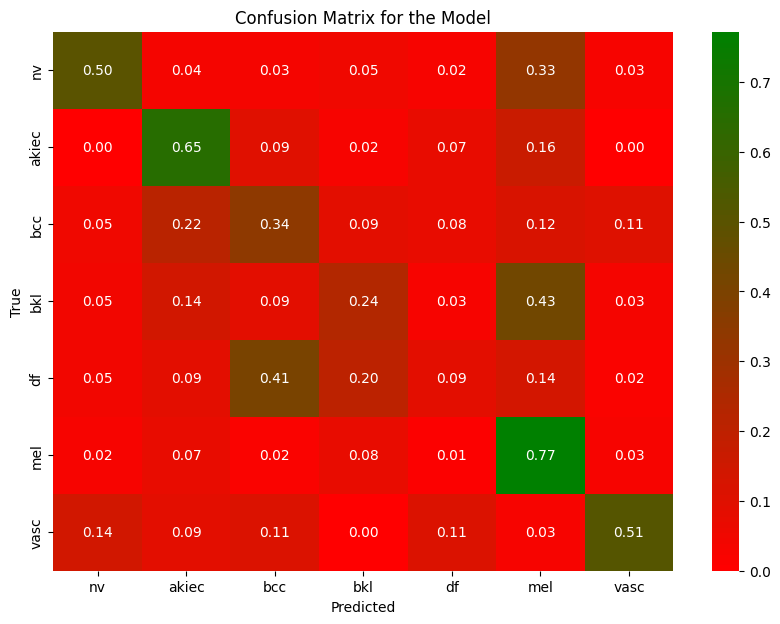

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

class_labels = ['nv', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

colors = ["red", "green"]  # Red to green
n_bins = 100
cmap_name = "custom_red_green"
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

predictions, true_labels = get_predictions(primary_model, test_loader)

cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cm, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the Model')
plt.savefig('normalized_confusion_matrix.png')
plt.show()

In [16]:
def evaluate2(net, loader, criterion, class_names):
    net.eval()
    total_loss = 0.0
    correct_predictions = 0.0
    total_samples = 0

    class_correct = [0 for _ in range(len(class_names))]
    class_total = [0 for _ in range(len(class_names))]
    class_loss = [0 for _ in range(len(class_names))]

    with torch.no_grad():
        for inputs, labels in loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = net(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)

            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1
                class_loss[label] += loss.item() / labels.size(0)

    avg_accuracy = correct_predictions / total_samples
    avg_loss = total_loss / len(loader)

    # Calculate per-class accuracy and average loss
    class_accuracies = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(class_correct))]
    class_avg_loss = [class_loss[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(class_loss))]

    net.train()  # Switch back to training mode
    return class_accuracies, class_avg_loss

In [17]:
criterion = nn.CrossEntropyLoss()
CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc')
accuracy, loss = evaluate2(primary_model, test_loader, criterion, CLASSES)

In [18]:
for index, item in enumerate(CLASSES):
    print(f"accuracy for {item} is {round(accuracy[index],4)*100}%")
    print(f"loss for {item} is {round(loss[index],4)}\n")

accuracy for nv is 49.89%
loss for nv is 0.02

accuracy for akiec is 65.12%
loss for akiec is 0.0192

accuracy for bcc is 34.410000000000004%
loss for bcc is 0.0211

accuracy for bkl is 23.5%
loss for bkl is 0.0208

accuracy for df is 9.09%
loss for df is 0.022

accuracy for mel is 77.19%
loss for mel is 0.0218

accuracy for vasc is 51.43%
loss for vasc is 0.0209



In [19]:
def map_labels_to_binary(label, cancer_classes):
    return 1 if label in cancer_classes else 0

# Define which classes are considered cancer
cancer_classes = {1, 2, 5}

binary_true_labels = [map_labels_to_binary(label, cancer_classes) for label in true_labels]
binary_predictions = [map_labels_to_binary(label, cancer_classes) for label in predictions]

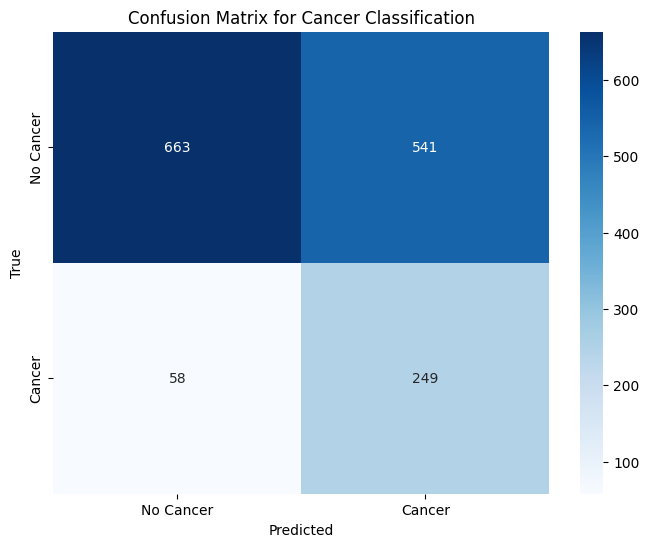

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

binary_cm = confusion_matrix(binary_true_labels, binary_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(binary_cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Cancer Classification')
plt.savefig('confusion_matrix.png')
plt.show()

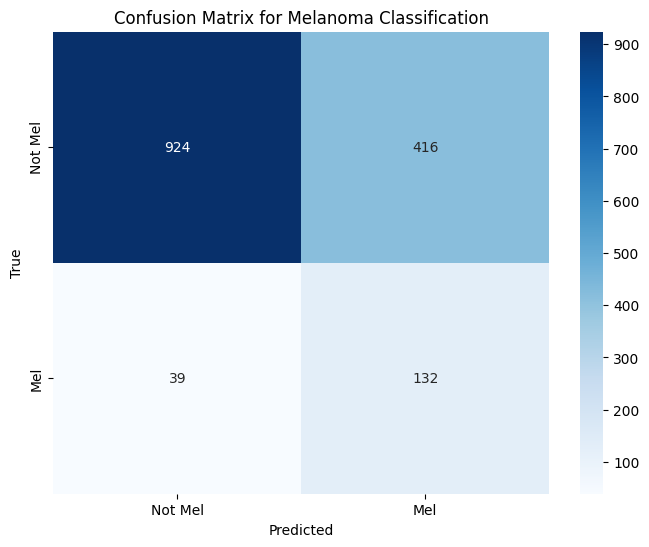

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

binary_true_labels = np.array([1 if label == 5 else 0 for label in true_labels])
binary_predictions = np.array([1 if label == 5 else 0 for label in predictions])

binary_cm = confusion_matrix(binary_true_labels, binary_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Mel', 'Mel'], yticklabels=['Not Mel', 'Mel'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Melanoma Classification')
plt.show()